# 第5章 大規模言語モデルのファインチューニング

**注意**
2023/7/28現在、MARC-jaのデータセットの配布元のリンクが切れており、書籍上の5.2、5.3、5.5.4節に掲載されているコードにおいて、データセット読み込みの箇所でエラーが出る状態です。こちらのノートブックは、MARC-jaと同様の感情分析のデータセットであるWRIMEを用いて書籍と同様のコードを実行するために用意されています。

## 5.2 感情分析モデルの実装

### 5.2.1 環境の準備

In [ ]:
!pip install transformers[ja,torch] datasets matplotlib japanize-matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 492.4/492.4 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 62.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 69.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 43.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... d

In [ ]:
from transformers.trainer_utils import set_seed

# 乱数シードを42に固定
set_seed(42)

### 5.2.2 データセットの準備

In [ ]:
from pprint import pprint
from datasets import load_dataset

# Hugging Face Hub上のllm-book/wrime-sentimentのリポジトリから
# データを読み込む
train_dataset = load_dataset("llm-book/wrime-sentiment", split="train")
valid_dataset = load_dataset("llm-book/wrime-sentiment", split="validation")
# pprintで見やすく表示する
pprint(train_dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

{'datetime': '2012/7/31 23:48',
 'label': 1,
 'sentence': 'ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…',
 'user_id': 1}


In [ ]:
pprint(train_dataset.features)

{'datetime': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'negative'], id=None),
 'sentence': Value(dtype='string', id=None),
 'user_id': Value(dtype='int64', id=None)}


### 5.2.3 トークナイザ

In [ ]:
from transformers import AutoTokenizer

# Hugging Face Hub上のモデル名を指定
model_name = "cl-tohoku/bert-base-japanese-v3"
# モデル名からトークナイザを読み込む
tokenizer = AutoTokenizer.from_pretrained(model_name)
# トークナイザのクラス名を確認
print(type(tokenizer).__name__)

BertJapaneseTokenizer


In [ ]:
tokenizer.tokenize("これはテストです。")

['これ', 'は', 'テスト', 'です', '。']

In [ ]:
encoded_input = tokenizer("これはテストです。")
# 出力されたオブジェクトのクラスを表示
print(type(encoded_input).__name__)

BatchEncoding


In [ ]:
pprint(encoded_input)

{'attention_mask': [1, 1, 1, 1, 1, 1, 1],
 'input_ids': [2, 12538, 465, 14985, 13037, 385, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0]}


In [ ]:
tokenizer.convert_ids_to_tokens(encoded_input["input_ids"])

['[CLS]', 'これ', 'は', 'テスト', 'です', '。', '[SEP]']

### 5.2.4 データセット統計の可視化

100%|██████████| 20149/20149 [00:04<00:00, 4297.22it/s]


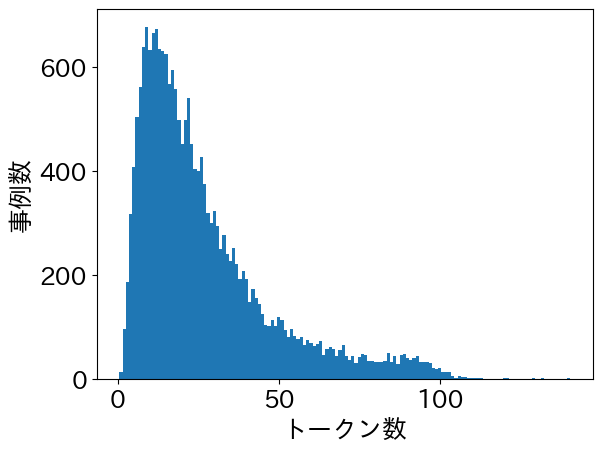

100%|██████████| 1608/1608 [00:00<00:00, 3422.12it/s]


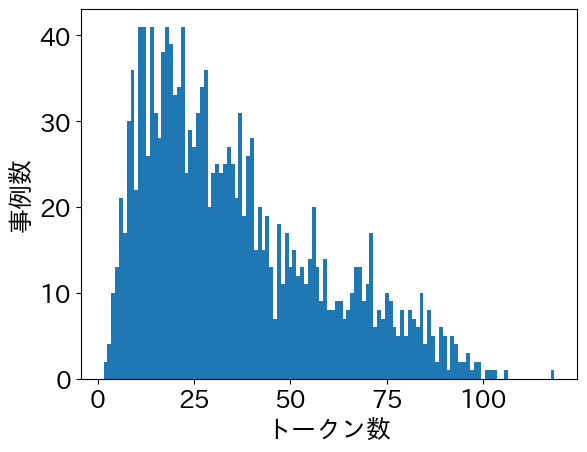

In [ ]:
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
from datasets import Dataset
from tqdm import tqdm

plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
    plt.xlabel("トークン数")
    plt.ylabel("事例数")
    plt.show()

visualize_text_length(train_dataset)
visualize_text_length(valid_dataset)

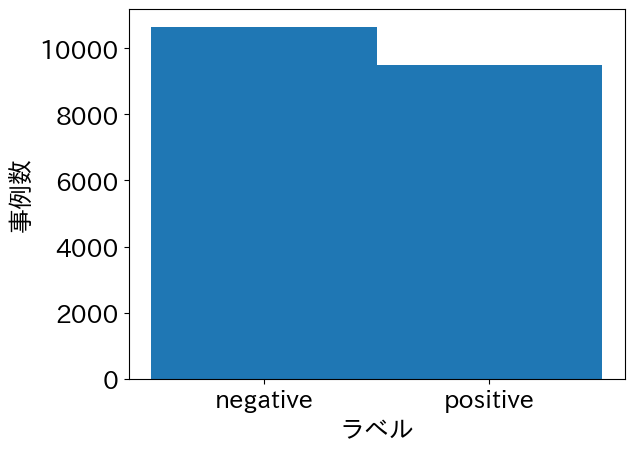

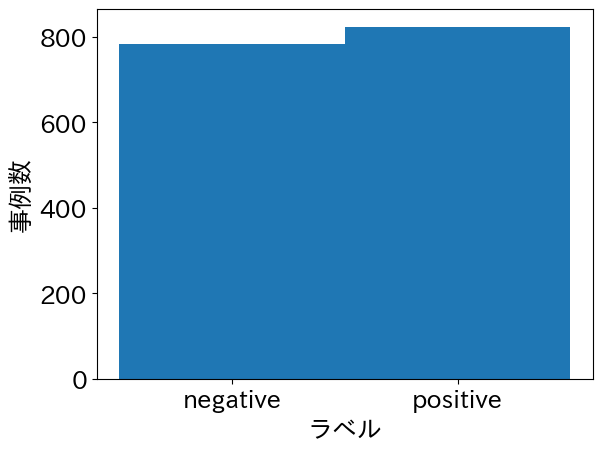

In [ ]:
def visualize_labels(dataset: Dataset):
    """データセット中のラベル分布をグラフとして描画"""
    # データセット中のラベルの数を数える
    label_counter = Counter()
    for data in dataset:
        label_id = data["label"]
        label_name = dataset.features["label"].names[label_id]
        label_counter[label_name] += 1
    # label_counterを棒グラフとして描画する
    plt.bar(label_counter.keys(), label_counter.values(), width=1.0)
    plt.xlabel("ラベル")
    plt.ylabel("事例数")
    plt.show()

visualize_labels(train_dataset)
visualize_labels(valid_dataset)

### 5.2.5 データセットの前処理

In [ ]:
from transformers import BatchEncoding

def preprocess_text_classification(
    example: dict[str, str | int]
) -> BatchEncoding:
    """文書分類の事例のテキストをトークナイズし、IDに変換"""
    encoded_example = tokenizer(example["sentence"], max_length=512)
    # モデルの入力引数である"labels"をキーとして格納する
    encoded_example["labels"] = example["label"]
    return encoded_example

In [ ]:
encoded_train_dataset = train_dataset.map(
    preprocess_text_classification,
    remove_columns=train_dataset.column_names,
)
encoded_valid_dataset = valid_dataset.map(
    preprocess_text_classification,
    remove_columns=valid_dataset.column_names,
)

Map:   0%|          | 0/20149 [00:00<?, ? examples/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Map:   0%|          | 0/1608 [00:00<?, ? examples/s]

In [ ]:
print(encoded_train_dataset[0])

{'input_ids': [2, 478, 7139, 15269, 441, 456, 13123, 21311, 12671, 385, 12651, 7065, 12485, 12488, 13781, 461, 457, 13030, 464, 461, 29, 29, 29, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 1}


### 5.2.6 ミニバッチ構築

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
batch_inputs = data_collator(encoded_train_dataset[0:4])
pprint({name: tensor.size() for name, tensor in batch_inputs.items()})

{'attention_mask': torch.Size([4, 36]),
 'input_ids': torch.Size([4, 36]),
 'labels': torch.Size([4]),
 'token_type_ids': torch.Size([4, 36])}


### 5.2.7 モデルの準備

In [ ]:
from transformers import AutoModelForSequenceClassification

class_label = train_dataset.features["label"]
label2id = {label: id for id, label in enumerate(class_label.names)}
id2label = {id: label for id, label in enumerate(class_label.names)}
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=class_label.num_classes,
    label2id=label2id,  # ラベル名からIDへの対応を指定
    id2label=id2label,  # IDからラベル名への対応を指定
)
print(type(model).__name__)

# パラメータをメモリ上に隣接した形で配置
# これを実行しない場合、モデルの保存でエラーになることがある
for param in model.parameters():
    param.data = param.data.contiguous()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification


In [ ]:
print(model.forward(**data_collator(encoded_train_dataset[0:4])))

SequenceClassifierOutput(loss=tensor(0.7499, grad_fn=<NllLossBackward0>), logits=tensor([[ 0.0755,  0.1869],
        [ 0.3045,  0.0093],
        [ 0.4099, -0.2517],
        [ 0.3643,  0.2986]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


### 5.2.8 訓練の実行

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output_wrime",  # 結果の保存フォルダ
    per_device_train_batch_size=32,  # 訓練時のバッチサイズ
    per_device_eval_batch_size=32,  # 評価時のバッチサイズ
    learning_rate=2e-5,  # 学習率
    lr_scheduler_type="linear",  # 学習率スケジューラの種類
    warmup_ratio=0.1,  # 学習率のウォームアップの長さを指定
    num_train_epochs=3,  # エポック数
    save_strategy="epoch",  # チェックポイントの保存タイミング
    logging_strategy="epoch",  # ロギングのタイミング
    evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
    load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
    metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
    fp16=True,  # 自動混合精度演算の有効化
    report_to="none",  # 外部ツールへのログを無効化
)

In [ ]:
import numpy as np

def compute_accuracy(
    eval_pred: tuple[np.ndarray, np.ndarray]
) -> dict[str, float]:
    """予測ラベルと正解ラベルから正解率を計算"""
    predictions, labels = eval_pred
    # predictionsは各ラベルについてのスコア
    # 最もスコアの高いインデックスを予測ラベルとする
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    train_dataset=encoded_train_dataset,
    eval_dataset=encoded_valid_dataset,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_accuracy,
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.312300,0.181143,0.933458
2,0.140000,0.171713,0.939055
3,0.073300,0.236369,0.941542


TrainOutput(global_step=1890, training_loss=0.17518099628428302, metrics={'train_runtime': 378.9218, 'train_samples_per_second': 159.524, 'train_steps_per_second': 4.988, 'total_flos': 2743024224330840.0, 'train_loss': 0.17518099628428302, 'epoch': 3.0})

### 5.2.9 訓練後のモデルの評価

In [ ]:
# 検証セットでモデルを評価
eval_metrics = trainer.evaluate(encoded_valid_dataset)
pprint(eval_metrics)

{'epoch': 3.0,
 'eval_accuracy': 0.9415422885572139,
 'eval_loss': 0.23636938631534576,
 'eval_runtime': 2.5236,
 'eval_samples_per_second': 637.193,
 'eval_steps_per_second': 20.209}


### 5.2.10 モデルの保存

Google Driveへの保存

In [ ]:
# Googleドライブをマウントする
from google.colab import drive

drive.mount("drive")

In [ ]:
# 保存されたモデルをGoogleドライブのフォルダにコピーする
!mkdir -p drive/MyDrive/llm-book
!cp -r output_wrime drive/MyDrive/llm-book

Hugging Face Hubへの保存

In [ ]:
from huggingface_hub import login

login()

In [ ]:
# Hugging Face Hubのリポジトリ名
# "YOUR-ACCOUNT"は自らのユーザ名に置き換えてください
repo_name = "YOUR-ACCOUNT/bert-base-japanese-v3-wrime-sentiment"
# トークナイザとモデルをアップロード
tokenizer.push_to_hub(repo_name)
model.push_to_hub(repo_name)